In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_days_ordered(count):
    for k,v in count.items():
        if v==1:
            return k       

Pull data from Looker:

In [4]:
import json
import requests
import configparser


#Read config file with Looker API and Database connection information
config = configparser.ConfigParser(allow_no_value=True)
config.read('config')

#Very Basic Looker API class allowing us to access the data from a given Look ID
class lookerAPIClient:
    def __init__(self, api_host=None, api_client_id=None, api_secret=None, api_port='19999'):
        auth_request_payload = {'client_id': api_client_id, 'client_secret': api_secret}
        self.host = api_host
        self.uri_stub = '/api/3.0/'
        self.uri_full = ''.join([api_host, ':', api_port, self.uri_stub])
        response = requests.post(self.uri_full + 'login', params=auth_request_payload)
        authData = response.json()
        self.access_token = authData['access_token']
        self.auth_headers = {
                'Authorization' : 'token ' + self.access_token,
                }

    def post(self, call='', json_payload=None):
        response = requests.post(self.uri_full + call, headers=self.auth_headers, json=json_payload)
        return response.json()

    def get(self, call=''):
        response = requests.get(self.uri_full + call, headers=self.auth_headers)
        return json.loads(response.content) #response.json()

    def runLook(self, look, limit):
        optional_arguments = '?' + 'limit=' + str(limit)
        return self.get('/'.join(['looks',look,'run','json'])+optional_arguments)

In [105]:
#Initialize the Looker API Class with the data in our config file (which is stored in a neighboring file 'config')
x = lookerAPIClient(
        api_host      = config.get('api', 'api_host'), 
        api_client_id = config.get('api', 'api_client_id'), 
        api_secret    = config.get('api', 'api_secret'), 
        api_port      = config.get('api', 'api_port')
        )   

In [106]:
# Use the API to get data from the Look 
orders = x.runLook(look='1760', limit=1000000)

In [107]:
df = pd.DataFrame(orders)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110520 entries, 0 to 110519
Data columns (total 8 columns):
orders.days_between_last_order_and_today              110520 non-null int64
user_order_days.months_ordered_pc_gc_in_first_year    108930 non-null float64
user_order_days.weeks_ordered_pc_gc_in_first_year     108930 non-null float64
user_order_facts.orders_within_month_1                110520 non-null int64
user_order_facts.orders_within_month_2                110520 non-null int64
user_order_facts.orders_within_year_1                 110520 non-null int64
user_use_cases_facts.first_use_case                   89895 non-null object
users.id                                              110520 non-null int64
dtypes: float64(2), int64(5), object(1)
memory usage: 6.7+ MB


In [109]:
df.head()

orders.days_between_last_order_and_today  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   user_order_days.months_ordered_pc_gc_in_first_year  \
0                                                 4.0   
1                                                 3.0   
2                                                 7.0   
3                                                 8.0   
4                                                 5.0   

   user_order_days.weeks_ordered_pc_gc_in_first_year  \
0                                                5.0   
1                                                6.0   
2                                                7.0   
3                                               14.0   
4                                                9.0   

   user_order_facts.orders_within_month_1  \
0                                       1   
1                                      30   
2                                       6   
3                                      23   
4                                      13   

   user_order_facts.orders_within_month_2  \
0                                       2   
1                                      30   
2                                       6   
3                                      23   
4                                      15   

   user_order_facts.orders_within_year_1 user_use_cases_facts.first_use_case  \
0                                      5                           thank you   
1                                     33                          travelling   
2                                     15                                None   
3                                     49                                None   
4                                     24                                None   

   users.id  
0  39765069  
1  39766691  
2  39774246  
3  39774515  
4  39772799

In [112]:
df.columns=['days_since_last_order', 'months_ordered_first_year', 'weeks_ordered_first_year', 'orders_month_1', 'orders_month_2', 'orders_year_1', 'first_use_case', 'user_id']

In [113]:
df.head()

days_since_last_order  months_ordered_first_year  weeks_ordered_first_year  \
0                      0                        4.0                       5.0   
1                      0                        3.0                       6.0   
2                      0                        7.0                       7.0   
3                      0                        8.0                      14.0   
4                      0                        5.0                       9.0   

   orders_month_1  orders_month_2  orders_year_1 first_use_case   user_id  
0               1               2              5      thank you  39765069  
1              30              30             33     travelling  39766691  
2               6               6             15           None  39774246  
3              23              23             49           None  39774515  
4              13              15             24           None  39772799

In [114]:
df['retained'] = df['days_since_last_order'].apply(lambda x: 1 if x <365 else 0)

In [115]:
df.drop('days_since_last_order', axis=1, inplace=True)

In [116]:
df.head()

months_ordered_first_year  weeks_ordered_first_year  orders_month_1  \
0                        4.0                       5.0               1   
1                        3.0                       6.0              30   
2                        7.0                       7.0               6   
3                        8.0                      14.0              23   
4                        5.0                       9.0              13   

   orders_month_2  orders_year_1 first_use_case   user_id  retained  
0               2              5      thank you  39765069         1  
1              30             33     travelling  39766691         1  
2               6             15           None  39774246         1  
3              23             49           None  39774515         1  
4              15             24           None  39772799         1

In [117]:
# add interaction features?
df['orders_after_month_2'] = df['orders_year_1'] - df['orders_month_2']

In [118]:
df['first_2_months_ratio'] = df['orders_month_2']/df['orders_year_1']

In [119]:
df.head()

months_ordered_first_year  weeks_ordered_first_year  orders_month_1  \
0                        4.0                       5.0               1   
1                        3.0                       6.0              30   
2                        7.0                       7.0               6   
3                        8.0                      14.0              23   
4                        5.0                       9.0              13   

   orders_month_2  orders_year_1 first_use_case   user_id  retained  \
0               2              5      thank you  39765069         1   
1              30             33     travelling  39766691         1   
2               6             15           None  39774246         1   
3              23             49           None  39774515         1   
4              15             24           None  39772799         1   

   orders_after_month_2  first_2_months_ratio  
0                     3              0.400000  
1                     3              0.909091  
2                     9              0.400000  
3                    26              0.469388  
4                     9              0.625000

In [51]:
# check the correlation between retention and features - find where it's >.50

In [120]:
df.corr()['retained']

months_ordered_first_year    0.505069
weeks_ordered_first_year     0.393757
orders_month_1               0.008504
orders_month_2               0.021578
orders_year_1                0.129522
user_id                      0.001449
retained                     1.000000
orders_after_month_2         0.270733
first_2_months_ratio        -0.630124
Name: retained, dtype: float64

In [ ]:
# only one that is highly correlated with retention is months_ordered_first_year, let's investigate further

In [127]:
ret = df[['user_id', 'retained', 'months_ordered_first_year', 'first_use_case']]
ret_dummies = pd.get_dummies(ret, columns=['months_ordered_first_year'])

In [128]:
ret_dummies.head()

user_id  retained first_use_case  months_ordered_first_year_1.0  \
0  39765069         1      thank you                              0   
1  39766691         1     travelling                              0   
2  39774246         1           None                              0   
3  39774515         1           None                              0   
4  39772799         1           None                              0   

   months_ordered_first_year_2.0  months_ordered_first_year_3.0  \
0                              0                              0   
1                              0                              1   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   months_ordered_first_year_4.0  months_ordered_first_year_5.0  \
0                              1                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              1   

   months_ordered_first_year_6.0  months_ordered_first_year_7.0  \
0                              0                              0   
1                              0                              0   
2                              0                              1   
3                              0                              0   
4                              0                              0   

   months_ordered_first_year_8.0  months_ordered_first_year_9.0  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              1                              0   
4                              0                              0   

   months_ordered_first_year_10.0  months_ordered_first_year_11.0  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   months_ordered_first_year_12.0  months_ordered_first_year_13.0  
0                               0                               0  
1                               0                               0  
2                               0                               0  
3                               0                               0  
4                               0                               0

In [129]:
correlated_cols = ret_dummies.columns[1:]

In [141]:
use_cases = ret_dummies['first_use_case'].unique()

In [142]:
use_cases

array(['thank you', 'travelling', None, 'just because', 'birthday',
       'parenting', 'holiday', 'bulk'], dtype=object)

In [148]:
correl = ret_dummies[correlated_cols].corr()

In [150]:
# make dataframe of correlation coefficients
retention_corrs = pd.DataFrame(data=correl[1:]['retained']).rename(columns={'retained':'all users'})

In [152]:
# add other use cases to dataframe
for uc in use_cases:
    retention_corrs[uc] = ret_dummies[ret_dummies['first_use_case']==uc][correlated_cols].corr()[1:]['retained']

In [153]:
retention_corrs

all users  thank you  travelling  NaN  \
months_ordered_first_year_1.0   -0.533730  -0.587978   -0.564205  NaN   
months_ordered_first_year_2.0   -0.115060  -0.141530   -0.014108  NaN   
months_ordered_first_year_3.0    0.125306   0.128714    0.173803  NaN   
months_ordered_first_year_4.0    0.190188   0.204715    0.172769  NaN   
months_ordered_first_year_5.0    0.184663   0.199167    0.153756  NaN   
months_ordered_first_year_6.0    0.161859   0.164871    0.128921  NaN   
months_ordered_first_year_7.0    0.133308   0.127898    0.107116  NaN   
months_ordered_first_year_8.0    0.113384   0.106564    0.085233  NaN   
months_ordered_first_year_9.0    0.093458   0.084561    0.070389  NaN   
months_ordered_first_year_10.0   0.077653   0.074723    0.053026  NaN   
months_ordered_first_year_11.0   0.064886   0.056097    0.048616  NaN   
months_ordered_first_year_12.0   0.054118   0.048470    0.038707  NaN   
months_ordered_first_year_13.0   0.042776   0.032038    0.029303  NaN   

                                just because  birthday  parenting   holiday  \
months_ordered_first_year_1.0      -0.568644 -0.552383  -0.497658 -0.464752   
months_ordered_first_year_2.0      -0.162111 -0.137277  -0.239767 -0.144047   
months_ordered_first_year_3.0       0.108518  0.128393  -0.000175  0.039885   
months_ordered_first_year_4.0       0.193086  0.189039   0.137940  0.177715   
months_ordered_first_year_5.0       0.187380  0.181619   0.162741  0.188061   
months_ordered_first_year_6.0       0.166948  0.142608   0.174544  0.149817   
months_ordered_first_year_7.0       0.138027  0.128883   0.149485  0.148708   
months_ordered_first_year_8.0       0.118546  0.100575   0.130114  0.139185   
months_ordered_first_year_9.0       0.097477  0.091144   0.110385  0.097612   
months_ordered_first_year_10.0      0.081482  0.075121   0.097270  0.062134   
months_ordered_first_year_11.0      0.070059  0.058515   0.083841  0.054757   
months_ordered_first_year_12.0      0.057328  0.049598   0.071732  0.050676   
months_ordered_first_year_13.0      0.047469  0.033014   0.065678  0.041347   

                                    bulk  
months_ordered_first_year_1.0  -0.592005  
months_ordered_first_year_2.0  -0.096656  
months_ordered_first_year_3.0   0.124960  
months_ordered_first_year_4.0   0.236189  
months_ordered_first_year_5.0   0.182061  
months_ordered_first_year_6.0   0.167250  
months_ordered_first_year_7.0   0.134545  
months_ordered_first_year_8.0   0.120461  
months_ordered_first_year_9.0   0.103497  
months_ordered_first_year_10.0  0.083427  
months_ordered_first_year_11.0  0.053349  
months_ordered_first_year_12.0  0.066969  
months_ordered_first_year_13.0  0.049375

In [156]:
retention_corrs.to_csv('retention_corrs_by_use_case.csv')

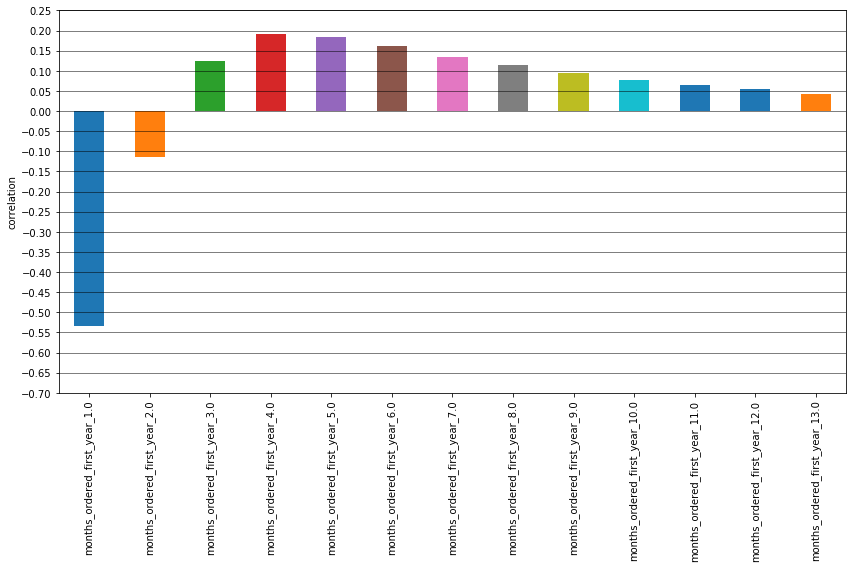

In [155]:
correl[1:].plot.bar(y='retained', legend=False, figsize=(12,8))
plt.ylim(-0.5, 0.2)
plt.yticks(np.arange(-0.7, 0.3, step=0.05))
plt.ylabel('correlation')
plt.grid(axis='y',linestyle='-', linewidth='0.5', color='black')
plt.tight_layout()
plt.savefig('retention_correl_all.png', transparent=True)